In [1]:
!pip install OWSLib
!pip install lxml

In [33]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image
import ipywidgets as widgets
from owslib.wms import WebMapService
import requests
from io import BytesIO
import PIL
import numpy as np

def produce_img(wms, layer_name):
    layer = wms[layer_name]
    bbox = layer.boundingBoxWGS84
    img  = wms.getmap(layers = [layer_name],
#                 styles = ['visual_bright'],
                 srs = 'EPSG:4326',
                 bbox = bbox,
                 size = (300, 250),
                 format = 'image/jpeg',
                 transparent=True)
    return Image(img.read())


def get_legend(wms, layer_name):
    try:
        layer = wms[layer_name]
        legend_url = layer.styles['default']['legend']
        legend_response = requests.get(legend_url)
        legend_img = PIL.Image.open(BytesIO(legend_response.content))
        return legend_img
    except KeyError:
        return None

def get_center(extent):
    extent = list(extent)
    min_long = extent[0]
    min_lat = extent[1]
    max_long = extent[2]
    max_lat = extent[3]
    return [np.mean([min_long, max_long]), np.mean([min_lat, max_lat])]

see example https://web2.nbmg.unr.edu/ArcGIS/services/CO_Data/COActiveFaults/MapServer/WMSServer?request=GetCapabilities&service=WMS

In [34]:
wms_url = 'https://web2.nbmg.unr.edu/ArcGIS/services/CO_Data/COActiveFaults/MapServer/WMSServer?request=GetCapabilities&service=WMS'

In [35]:
wms = WebMapService(wms_url)

In [36]:
layers = list(wms.contents)
menu = widgets.Dropdown(options = layers)
#the layer's name is called 0, ikr its bad
menu

Dropdown(options=('0',), value='0')

In [37]:
layer_img = produce_img(wms, menu.value)
legend_img = get_legend(wms, menu.value)

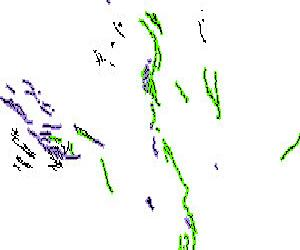

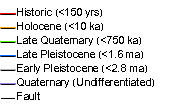

In [38]:
display(layer_img)
display(legend_img)

Try to display the image on an interactive map

In [39]:
import folium

In [40]:
lyr = wms[menu.value]

In [41]:
img  = wms.getmap(layers = ['0'],
#                 styles = ['visual_bright'],
                 srs = 'EPSG:4326',
                 bbox = lyr.boundingBoxWGS84,
                 size = (300, 250),
                 format = 'image/png',
                 transparent=True)

In [42]:
def format_coord(bound_tuple):
    bound_list = list(bound_tuple)
    min_coord = bound_list[:2][::-1]
    max_coord = bound_list[2:][::-1]
    return[min_coord, max_coord]

In [43]:
bbox = format_coord(lyr.boundingBoxWGS84)

In [44]:
bbox

[[37.000037, -109.304917], [40.167481, -103.219071]]

In [45]:
out = open('raster_image.png', 'wb')
out.write(img.read())
out.close() 

In [46]:
overlay_img = folium.raster_layers.ImageOverlay(
    name = menu.value,
    image = 'raster_image.png',
    bounds = bbox
)

In [47]:
center = get_center(lyr.boundingBoxWGS84)

In [49]:
width, height = 650, 500
m = folium.Map(location = center[::-1],
                  #tiles='Stamen Toner',
                  width=width,
                  height=height,
                  zoom_start=8)

In [50]:
overlay_img.add_to(m)

In [51]:
m

--------------------------------------------------------------------------------------------------------------------------

In [11]:
import folium
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
from cartopy.io import shapereader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [12]:
def make_map(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(9, 13),
                           subplot_kw=dict(projection=projection))
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

In [13]:
lyr = wms['0']

In [14]:
extent = list(lyr.boundingBoxWGS84)

In [15]:
wms.getOperationByName('GetMap').formatOptions

['image/bmp',
 'image/jpeg',
 'image/tiff',
 'image/png',
 'image/png8',
 'image/png24',
 'image/png32',
 'image/gif',
 'image/svg+xml']

In [16]:
img  = wms.getmap(layers = ['0'],
#                 styles = ['visual_bright'],
                 srs = 'EPSG:4326',
                 bbox = lyr.boundingBoxWGS84,
                 size = (300, 250),
                 format = 'image/png',
                 transparent=True)

In [17]:
# out = open('jpl_mosaic_visb.png', 'wb')
# out.write(img.read())
# out.close()

In [18]:
def get_center(extent):
    extent = list(extent)
    min_long = extent[0]
    min_lat = extent[1]
    max_long = extent[2]
    max_lat = extent[3]
    return [np.mean([min_long, max_long]), np.mean([min_lat, max_lat])]

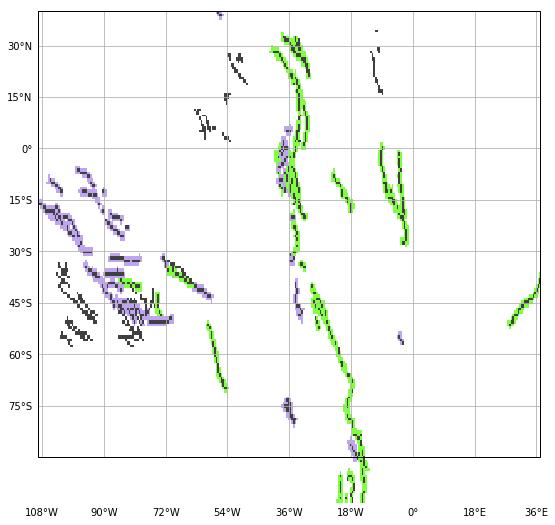

In [19]:
fig, ax = make_map()
image = plt.imread(img.geturl())
img_plot = ax.imshow(image, origin = 'upper', alpha=0.75, extent = extent)

In [31]:
import numpy as np
center = get_center(extent)
width, height = 650, 500
mapa = folium.Map(location = center[::-1],
                  min_lon=extent[0], max_lon=extent[2], min_lat=extent[1], max_lat=extent[3],
                  #tiles='Stamen Toner',
                  width=width,
                  height=height,
                  zoom_start=8)

# inline_map(mapa)
mapa


In [32]:
img.geturl()

'https://web2.nbmg.unr.edu/arcgis/services/CO_Data/COActiveFaults/MapServer/WmsServer?service=WMS&version=1.1.1&request=GetMap&layers=0&styles=&width=300&height=250&srs=EPSG%3A4326&bbox=-109.304917%2C37.000037%2C-103.219071%2C40.167481&format=image%2Fpng&transparent=TRUE&bgcolor=0xFFFFFF&exceptions=application%2Fvnd.ogc.se_xml'

In [33]:
extra = """
var imageUrl = 'https://web2.nbmg.unr.edu/arcgis/services/CO_Data/COActiveFaults/MapServer/WmsServer?service=WMS&version=1.1.1&request=GetMap&layers=0&styles=&width=300&height=250&srs=EPSG%3A4326&bbox=-109.304917%2C37.000037%2C-103.219071%2C40.167481&format=image%2Fpng&transparent=TRUE&bgcolor=0xFFFFFF&exceptions=application%2Fvnd.ogc.se_xml',
imageBounds = [[-109.304917, 37.000037], [-109.304917, 37.000037]];
L.imageOverlay(imageUrl, imageBounds).addTo(map);
"""

In [27]:
import fileinput


mapa.save(outfile="mapa.html")

add_lines = False
for line in fileinput.input('mapa.html', inplace=True):
    if 'map.addLayer(clusteredmarkers);' in line:
        add_lines = True
    else:
        if add_lines:
            print(extra)
        add_lines = False
    print(line)

-----------------------------------------------------------------------------------------------------------------------------

In [30]:
help(folium.raster_layers.ImageOverlay)

Help on class ImageOverlay in module folium.raster_layers:

class ImageOverlay(folium.map.Layer)
 |  Used to load and display a single image over specific bounds of
 |  the map, implements ILayer interface.
 |  
 |  Parameters
 |  ----------
 |  image: string, file or array-like object
 |      The data you want to draw on the map.
 |      * If string, it will be written directly in the output file.
 |      * If file, it's content will be converted as embedded in the output file.
 |      * If array-like, it will be converted to PNG base64 string and embedded in the output.
 |  bounds: list
 |      Image bounds on the map in the form [[lat_min, lon_min],
 |      [lat_max, lon_max]]
 |  opacity: float, default Leaflet's default (1.0)
 |  alt: string, default Leaflet's default ('')
 |  origin: ['upper' | 'lower'], optional, default 'upper'
 |      Place the [0,0] index of the array in the upper left or
 |      lower left corner of the axes.
 |  colormap: callable, used only for `mono` imag